### here we demonstrate how a model is attacked

#### pipeline:

1. load the model and test on clean images
1. get the training data format and modified it to desired adversarial output
1. pass the devised adversarial data as ground truth to the model and train the perturbation

In [1]:
import sys
from pathlib import Path

# insert the path first so that it overrides installed module
mmdet_root = Path('../detectors/mmdetection')
sys.path.insert(0, str(mmdet_root))
# vistool
vistool_root = Path('../detectors/')
sys.path.append(str(vistool_root))
sys.path

['../detectors/mmdetection',
 '/media/lab/Data/visual-attacks/darpa-aie/Code-TMVD/context-aware-attacks/attacks',
 '/home/lab/anaconda3/envs/vision/lib/python37.zip',
 '/home/lab/anaconda3/envs/vision/lib/python3.7',
 '/home/lab/anaconda3/envs/vision/lib/python3.7/lib-dynload',
 '',
 '/home/lab/.local/lib/python3.7/site-packages',
 '/home/lab/anaconda3/envs/vision/lib/python3.7/site-packages',
 '/home/lab/anaconda3/envs/vision/lib/python3.7/site-packages/correlation_cuda-0.0.0-py3.7-linux-x86_64.egg',
 '/home/lab/anaconda3/envs/vision/lib/python3.7/site-packages/IPython/extensions',
 '/home/lab/.ipython',
 '../detectors']

In [ ]:
# https://github.com/open-mmlab/mmcv#installation

# Check Pytorch installation
import torch, torchvision
# print(torch.__version__, torch.cuda.is_available())

# Check mmcv installation
import mmcv
# print(mmcv.__version__)
# from mmcv.ops import get_compiling_cuda_version, get_compiler_version
# print(get_compiling_cuda_version())
# print(get_compiler_version())

# Check MMDetection installation
import mmdet
# print(mmdet.__version__)

# import some common libraries
import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt

In [3]:
# https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb
# download the checkpoint from model zoo and put it in `checkpoints/`

from mmdet.apis import init_detector, inference_detector, show_result_pyplot

# Faster R-CNN
config_file = 'configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# RetinaNet
# config_file = 'configs/retinanet/retinanet_r50_fpn_1x_coco.py'
# checkpoint_file = 'checkpoints/retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth'

# SSD
# config_file = 'configs/ssd/ssd512_coco.py'
# checkpoint_file = 'checkpoints/ssd512_coco_20200308-038c5591.pth'

# YOLOv3
# config_file = 'configs/yolo/yolov3_d53_mstrain-416_273e_coco.py'
# checkpoint_file = 'checkpoints/yolov3_d53_mstrain-416_273e_coco-2b60fcd9.pth'

# GN+WS (Faster R-CNN)
# config_file = 'configs/gn+ws/faster_rcnn_r50_fpn_gn_ws-all_1x_coco.py'
# checkpoint_file = 'checkpoints/faster_rcnn_r50_fpn_gn_ws-all_1x_coco_20200130-613d9fe2.pth'

# Libra R-CNN (Faster R-CNN)
# config_file = 'configs/libra_rcnn/libra_faster_rcnn_r50_fpn_1x_coco.py'
# checkpoint_file = 'checkpoints/libra_faster_rcnn_r50_fpn_1x_coco_20200130-3afee3a9.pth'

# FCOS
# config_file = 'configs/fcos/fcos_r50_caffe_fpn_gn-head_mstrain_640-800_2x_coco.py'
# checkpoint_file = 'checkpoints/fcos_r50_caffe_fpn_gn-head_mstrain_640-800_2x_coco-d92ceeea.pth'

# FoveaBox
# config_file = 'configs/foveabox/fovea_r50_fpn_4x4_1x_coco.py'
# checkpoint_file = 'checkpoints/fovea_r50_fpn_4x4_1x_coco_20200219-ee4d5303.pth'

# FreeAnchor
# config_file = 'configs/free_anchor/retinanet_free_anchor_r50_fpn_1x_coco.py'
# checkpoint_file = 'checkpoints/retinanet_free_anchor_r50_fpn_1x_coco_20200130-0f67375f.pth'

# carafe
# config_file = 'configs/carafe/faster_rcnn_r50_fpn_carafe_1x_coco.py'
# checkpoint_file = 'checkpoints/faster_rcnn_r50_fpn_carafe_1x_coco_bbox_mAP-0.386_20200504_175733-385a75b7.pth'

# NAS-FPN
# config_file = 'configs/nas_fpn/retinanet_r50_nasfpn_crop640_50e_coco.py'
# checkpoint_file = 'checkpoints/retinanet_r50_nasfpn_crop640_50e_coco-0ad1f644.pth'

# DETR
# config_file = 'configs/detr/detr_r50_8x2_150e_coco.py'
# checkpoint_file = 'checkpoints/detr_r50_8x2_150e_coco_20201130_194835-2c4b8974.pth'

# NAS-FPN
# config_file = 'configs/deformable_detr/deformable_detr_r50_16x2_50e_coco.py'
# checkpoint_file = 'checkpoints/deformable_detr_r50_16x2_50e_coco_20210419_220030-a12b9512.pth'
    
# YOLOF
# config_file = 'configs/yolof/yolof_r50_c5_8x8_1x_coco.py'
# checkpoint_file = 'checkpoints/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth'


# init a detector
config_file = str(mmdet_root/config_file)
checkpoint_file = str(mmdet_root/checkpoint_file)
model = init_detector(config_file, checkpoint_file, device='cuda:0')

../../detectors/mmdetection/mmdet/models/utils/transformer.py:22: UserWarning: `MultiScaleDeformableAttention` in MMCV has been moved to `mmcv.ops.multi_scale_deform_attn`, please update your MMCV
  '`MultiScaleDeformableAttention` in MMCV has been moved to '


Use load_from_local loader


In [4]:
def GetHumanReadable(size,precision=2):
    suffixes=['B','KB','MB','GB','TB']
    suffixIndex = 0
    while size > 1024 and suffixIndex < 4:
        suffixIndex += 1 #increment the index of the suffix
        size = size/1024.0 #apply the division
    return "%.*f%s"%(precision,size,suffixes[suffixIndex])


# memory requirement for all parameters and buffers
mem_params = sum([param.nelement()*param.element_size() for param in model.parameters()])
mem_bufs = sum([buf.nelement()*buf.element_size() for buf in model.buffers()])
mem = mem_params + mem_bufs # in bytes
GetHumanReadable(mem)


# peak memory usage for the forward and backward pass?
mem = torch.cuda.max_memory_allocated()
GetHumanReadable(mem)

'163.26MB'

In [5]:
# test data pipeline
model.cfg.data.test.pipeline
for item in model.cfg.data.test.pipeline[1]['transforms']:
    if 'to_rgb' in item:
        print(item)
        to_rgb = item['to_rgb']
to_rgb

{'type': 'Normalize', 'mean': [123.675, 116.28, 103.53], 'std': [58.395, 57.12, 57.375], 'to_rgb': True}


True

../../detectors/mmdetection/mmdet/datasets/utils.py:68: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


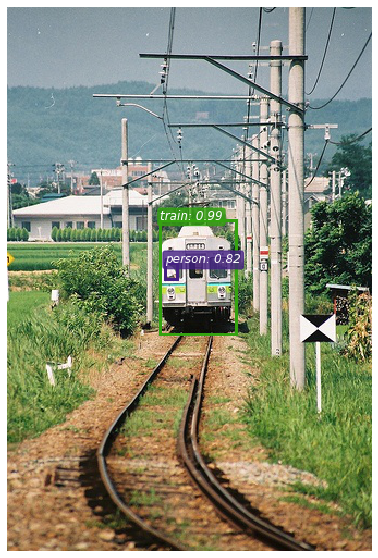

In [6]:
from pathlib import Path
voc_root = Path('../data/VOC/VOC2007/JPEGImages/')
voc_files = list(voc_root.glob('*.jpg'))

# path = 'demo/demo.jpg'
path = voc_files[1]
im = np.array(Image.open(path).convert('RGB'))
im_rgb = im
if not to_rgb:
    im = im[:,:,::-1]
    
result = inference_detector(model, im)
# # Let's plot the result
# show_result_pyplot(model, im, result, score_thr=0.3)

from vis_tool import vis_bbox_coco, COCO_BBOX_LABEL_NAMES
def output2det(outputs, conf_thres = 0.5):
    """Convert the model outputs to targeted format
    Args: conf_thres (float): confidence threshold
    Returns:
        det (numpy.ndarray): _bboxes(xyxy) - 4, _cls - 1, _prob - 1
    """
    det = []
    for idx, items in enumerate(outputs):
        for item in items:
            det.append(item[:4].tolist() + [idx] + item[4:].tolist())
    det = np.array(det)
    det = det[det[:,-1] >= conf_thres]
    return det

det = output2det(result)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1, 1, 1)
bboxes, labels, scores = det[:,:4], det[:,4], det[:,5]
vis_bbox_coco(im_rgb, bboxes, labels, scores, ax=ax)
plt.show()

## check test data pipeline

In [7]:
import mmcv
from mmdet.datasets import replace_ImageToTensor
from mmdet.datasets.pipelines import Compose
from mmcv.parallel import collate, scatter

cfg = model.cfg
device = next(model.parameters()).device
cfg = cfg.copy()
cfg.data.test.pipeline[0].type = 'LoadImageFromWebcam'
cfg.data.test.pipeline = replace_ImageToTensor(cfg.data.test.pipeline)
test_pipeline = Compose(cfg.data.test.pipeline)

datas = []
data = dict(img=im)
data = test_pipeline(data)
datas.append(data)
data = collate(datas, samples_per_gpu=1)

data['img_metas'] = [img_metas.data[0] for img_metas in data['img_metas']]
data['img'] = [img.data[0] for img in data['img']]

data = scatter(data, [device])[0]

In [8]:
data

{'img_metas': [[{'filename': None,
    'ori_filename': None,
    'ori_shape': (500, 335, 3),
    'img_shape': (1194, 800, 3),
    'pad_shape': (1216, 800, 3),
    'scale_factor': array([2.3880596, 2.388    , 2.3880596, 2.388    ], dtype=float32),
    'flip': False,
    'flip_direction': None,
    'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32),
     'std': array([58.395, 57.12 , 57.375], dtype=float32),
     'to_rgb': True}}]],
 'img': [tensor([[[[0.5536, 0.5707, 0.6221,  ..., 0.3481, 0.2967, 0.2967],
            [0.6049, 0.6049, 0.6392,  ..., 0.3309, 0.3138, 0.2967],
            [0.7419, 0.7248, 0.6563,  ..., 0.3138, 0.3138, 0.3309],
            ...,
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
  
           [[0.5553, 0.5728, 0.6254,  ..., 0.3102, 0.2752, 0.2577],
            [0.5903, 0.6078, 0.6429, 

In [10]:
results = model(return_loss=False, rescale=True, **data)

In [11]:
test_pipeline

Compose(
    LoadImageFromWebcam(to_float32=False, color_type='color', file_client_args={'backend': 'disk'})
    MultiScaleFlipAug(transforms=Compose(
    Resize(img_scale=None, multiscale_mode=range, ratio_range=None, keep_ratio=True, bbox_clip_border=True)
    RandomFlip(flip_ratio=None)
    Normalize(mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375], to_rgb=True)
    Pad(size=None, size_divisor=32, pad_val=0)
    DefaultFormatBundle
    Collect(keys=['img'], meta_keys=('filename', 'ori_filename', 'ori_shape', 'img_shape', 'pad_shape', 'scale_factor', 'flip', 'flip_direction', 'img_norm_cfg'))
), img_scale=[(1333, 800)], flip=False, flip_direction=['horizontal'])
)

## check train data pipeline

In [12]:
import mmcv
from mmdet.models import build_detector
from mmcv.runner import load_checkpoint

# same as test
# config_file = 'configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
# checkpoint_file = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

device='cuda:0'
config = mmcv.Config.fromfile(config_file)

model_train = build_detector(config.model, test_cfg=config.get('test_cfg'))

map_loc = 'cpu' if device == 'cpu' else None
checkpoint = load_checkpoint(model_train, checkpoint_file, map_location=map_loc)
if 'CLASSES' in checkpoint.get('meta', {}):
    model_train.CLASSES = checkpoint['meta']['CLASSES']
    
model_train.cfg = config  # save the config in the model for convenience
model_train.to(device)
# model_train.eval();
model_train.train();

../../detectors/mmdetection/mmdet/models/detectors/two_stage.py:28: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '
../../detectors/mmdetection/mmdet/models/backbones/resnet.py:400: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '


Use load_from_local loader


In [13]:
bboxes = det[:,:4][:1].astype(np.float32)
labels = det[:,4][:1].astype(np.long)

In [14]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from torch.nn import functional as F
from torchvision import transforms

# with im
# path = data['img_metas'][0]['filename']
# im = np.array(Image.open(path).convert('RGB'))[:,:,::-1]

data_train = data.copy()
data_train['img_metas'] = data_train['img_metas'][0]
data_train['img'] = data_train['img'][0]

''' from file: datasets/pipelines/transforms.py '''
img = torch.from_numpy(im.copy().transpose((2, 0, 1)))[None].float().cuda()
pert = torch.zeros_like(img)
pert.requires_grad = True
img = (img + pert).clamp(0,255)


# 'type': 'Resize', 'keep_ratio': True, (1333, 800)
ori_sizes = im.shape[:2]
image_sizes = data_train['img_metas'][0]['img_shape'][:2]
w_scale = image_sizes[1] / ori_sizes[1]
h_scale = image_sizes[0] / ori_sizes[0]
scale_factor = np.array([w_scale, h_scale, w_scale, h_scale], dtype=np.float32)

gt_bboxes = bboxes * scale_factor
gt_bboxes[:, 0::2] = np.clip(gt_bboxes[:, 0::2], 0, image_sizes[1])
gt_bboxes[:, 1::2] = np.clip(gt_bboxes[:, 1::2], 0, image_sizes[0])
data_train['gt_bboxes'] = [torch.from_numpy(gt_bboxes).cuda()]
data_train['gt_labels'] = [torch.from_numpy(labels).cuda()]


# img = F.interpolate(img, size=image_sizes, mode='nearest')
img = F.interpolate(img, size=image_sizes, mode='bilinear', align_corners=True)

# 'type': 'Normalize', 'mean': [103.53, 116.28, 123.675], 'std': [1.0, 1.0, 1.0], 'to_rgb': False
img_norm_cfg = data_train['img_metas'][0]['img_norm_cfg']
mean = img_norm_cfg['mean']
std = img_norm_cfg['std']
transform = transforms.Normalize(mean=mean, std=std)
img = transform(img)

# 'type': 'Pad', 'size_divisor': 32
pad_sizes = data_train['img_metas'][0]['pad_shape'][:2]
left = top = 0
bottom = pad_sizes[0] - image_sizes[0]
right = pad_sizes[1] - image_sizes[1]
img = F.pad(img, (left, right, top, bottom), "constant", 0)
data_train['img'] = img

In [15]:
data_train

{'img_metas': [{'filename': None,
   'ori_filename': None,
   'ori_shape': (500, 335, 3),
   'img_shape': (1194, 800, 3),
   'pad_shape': (1216, 800, 3),
   'scale_factor': array([2.3880596, 2.388    , 2.3880596, 2.388    ], dtype=float32),
   'flip': False,
   'flip_direction': None,
   'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32),
    'std': array([58.395, 57.12 , 57.375], dtype=float32),
    'to_rgb': True},
   'batch_input_shape': (1216, 800)}],
 'img': tensor([[[[ 0.1254,  0.1827,  0.2400,  ..., -0.1255, -0.1542, -0.1828],
           [ 0.2687,  0.2301,  0.1916,  ..., -0.1699, -0.1656, -0.1613],
           [ 0.4120,  0.2776,  0.1432,  ..., -0.2143, -0.1771, -0.1398],
           ...,
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
          [[ 0.5553,  0.6139,  0.6724,  ...,  0.3455

In [ ]:
loss_dict = model_train(return_loss=True, **data_train)
loss_dict

In [ ]:
# losses = sum(loss_dict.values())
losses = loss_dict['loss_cls'] + loss_dict['loss_bbox'] + sum(loss_dict['loss_rpn_cls']) + sum(loss_dict['loss_rpn_bbox'])
losses.backward()
pert.grad.shape

## attack

In [24]:
# mis-categorizing
bboxes = det[:,:4]
labels = det[:,4]
labels[:] = 1

# bboxes = det[:,:4][:1]
# labels = det[:,4][:1]
# labels[0] = 1

# vanishing
# bboxes = det[:,:4][:0]
# labels = det[:,4][:0]

bboxes = bboxes.astype(np.float32)
labels = labels.astype(np.long)

print(bboxes, labels)
print([model.CLASSES[i] for i in labels])

[[144.9311  235.1554  156.01147 249.66678]
 [140.1369  195.60315 210.04753 300.12878]] [1 1]
['bicycle', 'bicycle']


In [25]:
def get_loss_from_dict(model_type, loss_dict):
    """Return the correct loss based on the model type
    Args:
        model_type (~ str): the type of the model, eg: 'FasterRCNN' or 'YOLOV3'
        loss_dict (~ dict): the loss of the model, stored in a dictionary
    Returns:
        losses (~ torch.Tensor): the summation of the loss
    """
    if model_type in ['FasterRCNN']: # frcnn, foveabox, Libra R-CNN, GN+WS 
        losses = loss_dict['loss_cls'] + loss_dict['loss_bbox'] + sum(loss_dict['loss_rpn_cls']) + sum(loss_dict['loss_rpn_bbox'])
    elif model_type in ['RetinaNet', 'SingleStageDetector']: # retina, ssd
        losses = sum(loss_dict['loss_cls']) + sum(loss_dict['loss_bbox'])
    elif model_type in ['YOLOV3']: # yolov3        
        losses = sum(loss_dict['loss_cls']) + sum(loss_dict['loss_conf']) + sum(loss_dict['loss_xy']) + sum(loss_dict['loss_wh'])
    elif model_type in ['FCOS']:
        losses = loss_dict['loss_cls'] + loss_dict['loss_bbox'] + loss_dict['loss_centerness']
    elif model_type in ['DETR']:
        losses = sum(loss_dict.values())
        # losses = loss_dict['loss_cls'] + loss_dict['loss_bbox'] + loss_dict['loss_iou']
    else:
        print('not implemented!')
    return losses

100%|██████████| 50/50 [00:09<00:00,  5.45it/s]


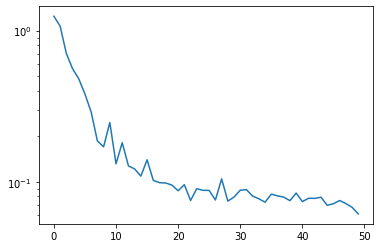

In [33]:
from PIL import Image
from tqdm import tqdm
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt
from torch.nn import functional as F
from torchvision import transforms

# with im
# path = data['img_metas'][0]['filename']
# im = np.array(Image.open(path).convert('RGB'))[:,:,::-1]

# alpha = 5
alpha = 2
eps = 20
n_iters = 50

data_train = data.copy()
data_train['img_metas'] = data_train['img_metas'][0]
data_train['img'] = data_train['img'][0]

''' from file: datasets/pipelines/transforms.py '''

img0 = torch.from_numpy(im.copy().transpose((2, 0, 1)))[None].float().cuda()
pert = torch.zeros_like(img0)
LOG = defaultdict(list)
for i in tqdm(range(n_iters)):
    pert.requires_grad = True
    img = (img0 + pert).clamp(0,255)

    # 'type': 'Resize', 'keep_ratio': True, (1333, 800)
    ori_sizes = im.shape[:2]
    image_sizes = data_train['img_metas'][0]['img_shape'][:2]
    w_scale = image_sizes[1] / ori_sizes[1]
    h_scale = image_sizes[0] / ori_sizes[0]
    scale_factor = np.array([w_scale, h_scale, w_scale, h_scale], dtype=np.float32)

    gt_bboxes = bboxes * scale_factor
    gt_bboxes[:, 0::2] = np.clip(gt_bboxes[:, 0::2], 0, image_sizes[1])
    gt_bboxes[:, 1::2] = np.clip(gt_bboxes[:, 1::2], 0, image_sizes[0])
    data_train['gt_bboxes'] = [torch.from_numpy(gt_bboxes).cuda()]
    data_train['gt_labels'] = [torch.from_numpy(labels).cuda()]

    img = F.interpolate(img, size=image_sizes, mode='bilinear', align_corners=True)
    
    # 'type': 'Normalize', 'mean': [103.53, 116.28, 123.675], 'std': [1.0, 1.0, 1.0], 'to_rgb': False
    img_norm_cfg = data_train['img_metas'][0]['img_norm_cfg']
    mean = img_norm_cfg['mean']
    std = img_norm_cfg['std']
    transform = transforms.Normalize(mean=mean, std=std)
    img = transform(img)

    # 'type': 'Pad', 'size_divisor': 32
    pad_sizes = data_train['img_metas'][0]['pad_shape'][:2]
    left = top = 0
    bottom = pad_sizes[0] - image_sizes[0]
    right = pad_sizes[1] - image_sizes[1]
    img = F.pad(img, (left, right, top, bottom), "constant", 0)
    data_train['img'] = img
    
    # get loss and backpropagate
    loss_dict = model_train(return_loss=True, **data_train)
    model_type = model.cfg.model.type
    losses = get_loss_from_dict(model_type, loss_dict)
    losses.backward()
    with torch.no_grad():
        # ifgsm
        pert = pert - alpha*torch.sign(pert.grad)
        pert = pert.clamp(min=-eps, max=eps)
        LOG['loss'].append(losses.item())

plt.plot(LOG['loss'])
plt.yscale('log')

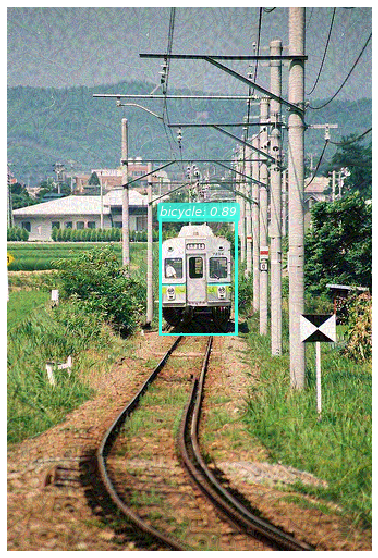

In [34]:
pert_np = pert.squeeze().cpu().numpy().transpose(1, 2, 0)
adv = (im + pert_np).clip(0,255).astype(np.uint8)

result_adv = inference_detector(model, adv)
det_adv = output2det(result_adv)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1, 1, 1)
if to_rgb:
    vis_bbox_coco(adv, det_adv[:,:4], det_adv[:,4], det_adv[:,5], ax=ax)
else:
    vis_bbox_coco(adv[:,:,::-1], det_adv[:,:4], det_adv[:,4], det_adv[:,5], ax=ax)

In [35]:
det_adv

array([[140.16346741, 191.25416565, 210.17251587, 299.88223267,
          1.        ,   0.8949241 ]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(0.0, 20.0)

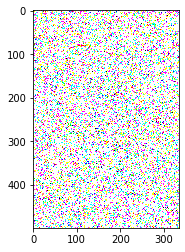

In [36]:
diff = np.abs(adv/1.0-im/1.0)
plt.imshow(diff)
diff.min(), diff.max()